In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from matplotlib import rcParams
from tqdm import tqdm
from pyfcd.fcd import calculate_carriers
from scipy.signal import find_peaks,savgol_filter
from scipy.optimize import curve_fit
import utilities as ut

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
FRAME_PER_SECOND = 60
plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

rcParams['savefig.bbox'] = 'tight'

# Cuba grande sin zoom

In [6]:
PX_PER_MM = 4.856496282194044

mask = [50,650,200,1100] # ymin, ymax, xmin, xmax

try:
    df = pd.read_csv('10Vpp-relacion_dispersion_sinzoom.csv')
    freq = df['freq [Hz]']
    lambdas = df['lambda [px]']/PX_PER_MM
    delta_lambdas = df['delta_lambda [px]']/PX_PER_MM
    delta_omega = df['delta_freq [Hz]']*(2*np.pi)
except FileNotFoundError:
    for i in tqdm(np.arange(6,30 + 1)):
        
        lambdas = np.array([])
        delta_lambdas = np.array([])
        freq = np.array([])
        
        FILEPATH= 'wavedriver/cuba_grande_sinzoom/'
        FILENAME= '10Vpp-'+str(i)+'Hz'
        if FILENAME+'.mp4' in os.listdir(FILEPATH):
            try:
                maps = np.load(f'{FILEPATH}/{FILENAME}.npz', allow_pickle=True)['maps']
            except FileNotFoundError:
                vs = cv.VideoCapture(f'{FILEPATH}/{FILENAME}.mp4')
                ref_frame = ut.load_ref_frame_and_try_mask(vs, mask)
                carriers = calculate_carriers(ref_frame, MM_PER_PX = None)
                vs = cv.VideoCapture(f'{FILEPATH}/{FILENAME}.mp4')
                maps = ut.obtener_deformacion(vs,carriers, start=int(2*FRAME_PER_SECOND), finish = int(4*FRAME_PER_SECOND), SHOW=True, mask = mask)
                
                np.savez(f'{FILEPATH}/{FILENAME}.npz', maps= maps)
            
            # Actualizo las dimensiones de las imágenes
            X_LEN = maps[0].shape[1]
            Y_LEN = maps[0].shape[0]

            min_x = 125
            max_x = X_LEN
            n = 50
            avg_x = (max_x + min_x)/2
            wave_point_y = Y_LEN//2
            wave_point_x = int(avg_x)

            main_freq = ut.get_main_frequency(deformation_maps= maps,
                                        y0= wave_point_y,
                                        x0= wave_point_x, DEBUG=False)

            kwargs_find_peaks = dict({
                "width":10,
                "rel_height":0.3
            })

            wavelength, delta_wavelength = ut.get_lambda_w_error(deformation_maps= maps, 
                                                            main_freq= main_freq,
                                                            y0= wave_point_y,
                                                            min_x= min_x,
                                                            max_x= max_x,
                                                            n= n, DEBUG=False,
                                                            **kwargs_find_peaks)

            lambdas = np.append(lambdas, wavelength)
            delta_lambdas = np.append(delta_lambdas, delta_wavelength)
            freq = np.append(freq,main_freq)
        else: continue

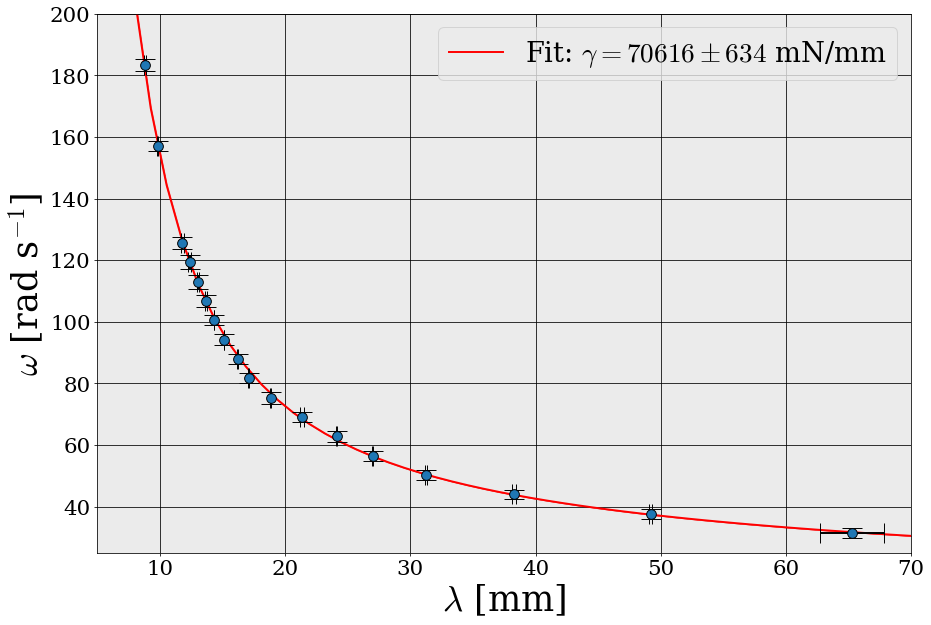

In [10]:
w_k_teorica = lambda l,b: np.sqrt(9810*(2*np.pi/l) + b*(2*np.pi/l)**3*np.tanh((2*np.pi/l)*65))

popt,popv = curve_fit(f=w_k_teorica, ydata=2*np.pi*np.array(freq), xdata=lambdas, sigma=delta_omega)

err_popt = np.sqrt(np.diag(popv))

ls = np.linspace(8,70)

w_real = w_k_teorica(ls,70e3)
ws = w_k_teorica(ls,*popt)
ws_down = w_k_teorica(ls, popt[0] - err_popt[0])
ws_up = w_k_teorica(ls, popt[0] + err_popt[0])
omega = 2*np.pi*np.array(freq) #

plt.errorbar(lambdas, omega, markerfacecolor = 'tab:blue', fmt='o',
            yerr = delta_omega, xerr = delta_lambdas, color = 'k', ecolor = 'k',
            ms=10, elinewidth=2, lw=3, capsize=10, zorder=3,)

plt.fill_between(ls, y1 = ws_down, y2 = ws_up, zorder=0, color='r', alpha=0.5)
plt.plot(ls,ws,color='r',lw=2, label=f'Fit: $\gamma={popt[0]:.0f} \pm {err_popt[0]:.0f}$ mN/mm',zorder=1)

plt.ylabel('$\omega$ [rad s$^{-1}$]')
plt.xlabel('$\lambda$ [mm]')
plt.xlim([5,70])
plt.ylim([25,200])
plt.legend()

# Pruebas

In [56]:
vs = cv.VideoCapture(f'{FILEPATH}/{FILENAME}.mp4')
maps = ut.obtener_imagenes_crudas(vs, SHOW=True,start=3*FRAME_PER_SECOND, finish=7*FRAME_PER_SECOND, mask = mask)

In [58]:
for i_frame in tqdm(np.arange(len(maps))):
    fig = plt.figure()
    plt.imshow(maps[i_frame], aspect='equal')
    plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
    plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.yticks()[0][1:-1]])

    plt.ylabel('z [mm]')
    plt.xlabel('x [mm]')
    plt.grid()
    fig.tight_layout()
    plt.savefig(f'{FILEPATH}/{FILENAME}/images_bw/{i_frame:03}.tiff')
    plt.cla()
    plt.clf()
    plt.close()

  0%|          | 0/241 [00:00<?, ?it/s]

100%|██████████| 241/241 [01:57<00:00,  2.05it/s]


In [59]:
mask = [50,650,200,1100] # ymin, ymax, xmin, xmax
PX_PER_MM = 4.856496282194044
FILEPATH= 'wavedriver/cuba_grande_sinzoom/'
FILENAME='10Vpp-18Hz'
vs = cv.VideoCapture(f'{FILEPATH}/{FILENAME}.mp4')
ref_frame = ut.load_ref_frame_and_try_mask(vs, mask)

In [60]:
vs = cv.VideoCapture(f'{FILEPATH}/{FILENAME}.mp4')
carriers = calculate_carriers(ref_frame, MM_PER_PX = (PX_PER_MM)**(-1))
maps = ut.obtener_deformacion(vs,carriers, start=int(3*FRAME_PER_SECOND), finish = int(7*FRAME_PER_SECOND), SHOW=True, mask = mask)

X_LEN = maps[0].shape[1]
Y_LEN = maps[0].shape[0]

In [55]:
ut.save_deformation_maps(PATH=f"{FILEPATH}/{FILENAME}/images",maps=maps,PX_PER_MM=PX_PER_MM)

100%|██████████| 241/241 [02:13<00:00,  1.81it/s]


In [61]:
min_x = 125
max_x = X_LEN

avg_x = (max_x + min_x)/2

wave_point_y = Y_LEN//2
wave_point_x = int(avg_x)

max_height = max([abs(maps[i]).max() for i in np.arange(len(maps))])
norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)

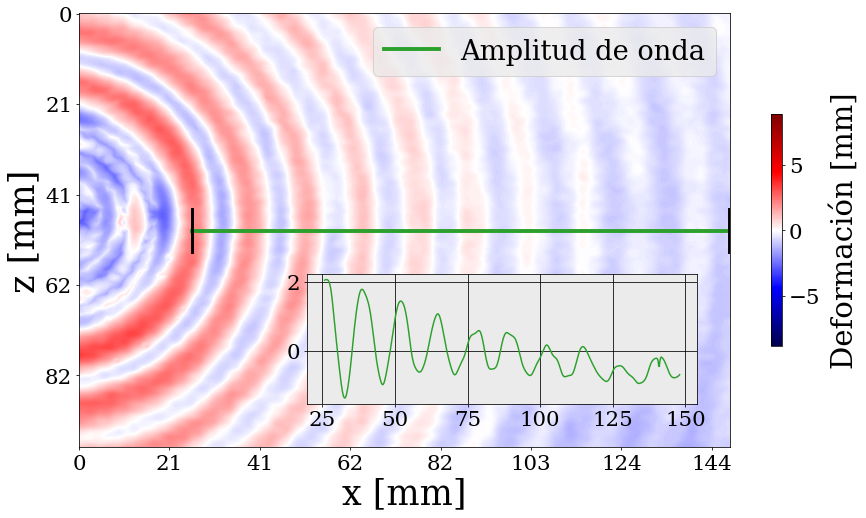

In [62]:
i_frame = 20

x0 = np.array([avg_x - 2*avg_x//4, avg_x, avg_x + 2*avg_x//4]).astype(int)

fig = plt.figure()
plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [f'{i/PX_PER_MM:.0f}' for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [f'{i/PX_PER_MM:.0f}' for i in plt.yticks()[0][1:-1]])

cbar_term = plt.colorbar(pad=5e-2, shrink=0.43)
cbar_term.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)

plt.axvline(min_x, ymin=0.45,ymax=0.55, color='k', lw=3,zorder=1)
plt.axvline(max_x-1,ymin=0.45,ymax=0.55, color='k', lw=3,zorder=1)
plt.axhline(Y_LEN//2,xmin=min_x/X_LEN,xmax=(max_x)/X_LEN, color='tab:green', lw=4, label='Amplitud de onda', zorder=0)

axins = fig.axes[0].inset_axes([0.35, 0.1, 0.6, 0.3], xlim=(min_x,max_x), ylim=(wave_point_y+5,wave_point_y-5))
axins.clear()
axins.plot(np.arange(min_x,max_x)/PX_PER_MM, maps[i_frame][wave_point_y, min_x:max_x], color='tab:green')

plt.ylabel('z [mm]')
plt.xlabel('x [mm]')
plt.grid()
plt.xlim([0,X_LEN])
plt.legend()

In [63]:
wave_time = [frame[wave_point_y, wave_point_x] for frame in maps]
fr = np.linspace(0, FRAME_PER_SECOND//2, len(wave_time)//2 + 1)
wave_fft = np.abs(np.fft.rfft(wave_time))**2
peak_fft = find_peaks(wave_fft, height=1e-3)[0]
max_peak_fft = np.argmax(wave_fft[peak_fft])
main_freq = fr[peak_fft[max_peak_fft]]
print(main_freq)

18.0


(42.7109632034632, 0.2726624225189449)

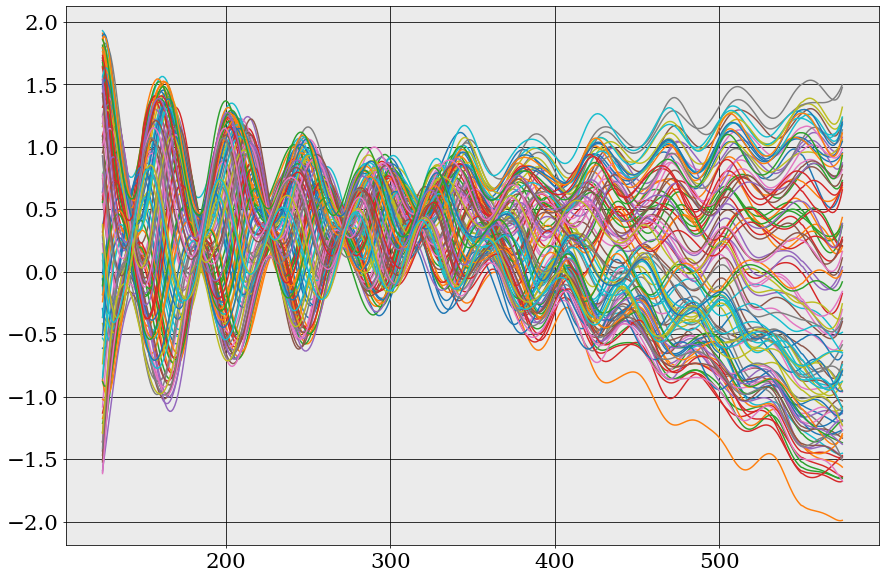

In [359]:
n = 50
xs = np.arange(min_x,max_x)
wave_length = np.zeros(len(maps))

for i_frame in np.arange(len(maps) - 1)[20::int(main_freq**(-1)*FRAME_PER_SECOND)]:
    wave = maps[i_frame][wave_point_y, min_x:max_x]
    wave = savgol_filter(wave, n, polyorder=5)
    wave_peaks = find_peaks(wave, width=[15,250])[0]
    
    plt.plot(xs, wave)
    # plt.plot(xs[wave_peaks], wave[wave_peaks], 'x', color='r', markeredgewidth=2)
    
    if len(wave_peaks)>1:
        wave_length[i_frame] = np.diff(xs[wave_peaks]).mean()

wavelength = np.mean(wave_length[wave_length!=0])
delta_wavelength = np.std(wave_length[wave_length!=0])/np.sqrt(len(wave_length[wave_length!=0]))
(wavelength, delta_wavelength)

In [360]:
w2_k_teorica = lambda l,a,b: (a*(2*np.pi/l) + b*(2*np.pi/l)**3)*np.tanh((2*np.pi/l)*62)
deriv_w2_k_teorica = lambda l,a,b,c: (a*(2*np.pi/l) + b*(2*np.pi/l)**3)*(1/np.cosh(c*(2*np.pi/l))**2)*(c/l**2) + (a*(2*np.pi/l)**2 + b*(2*np.pi/l)**4)*np.tanh(c*(2*np.pi/l))
w2 = w2_k_teorica(wavelength/PX_PER_MM,9810,70e3)
err_w2 = deriv_w2_k_teorica(wavelength, 9810, 70e3, 62)*delta_wavelength/PX_PER_MM

omega = np.sqrt(w2)
err_omega = .5*w2**(-1/2)*err_w2
print("Valor de omega:", omega)
print("Error de omega:", err_omega)

print("Valor de frecuencia:", omega/(2*np.pi))
print("Error de frecuencia:", err_omega/(2*np.pi))

Valor de omega: 180.3745312764042
Error de omega: 0.03814272658113379
Valor de frecuencia: 28.70749826052341
Error de frecuencia: 0.006070603478390072


Máximo interpolado en 18.0 Hz con un ancho a media altura de 0.36036414550206786 Hz


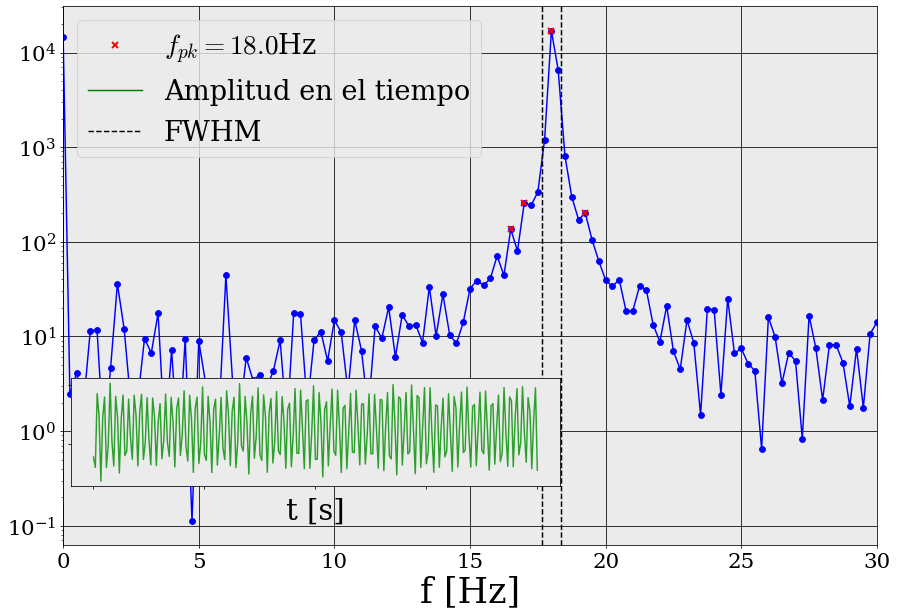

In [88]:
wave_point_y = Y_LEN//2
wave_point_x = int(avg_x)

wave = [frame[wave_point_y, wave_point_x] for frame in maps]
fr = np.linspace(0, FRAME_PER_SECOND//2, len(wave)//2 + 1)
wave_fft = np.abs(np.fft.rfft(wave))**2
peak_fft = find_peaks(wave_fft, height=1e2)[0]
max_peak_fft = np.argmax(wave_fft[peak_fft])

fwhm = ut.get_fwhm(fr,wave_fft)

fig = plt.figure()

plt.plot(fr,wave_fft, 'o-', color='blue')
plt.plot(fr[peak_fft],wave_fft[peak_fft], 'x', color='r', markeredgewidth=2, label=f'$f_{{pk}} = {fr[peak_fft[max_peak_fft]]:.1f}$Hz')
plt.axvline(x=50,color='g',label='Amplitud en el tiempo')
plt.axvline(x=fr[peak_fft[max_peak_fft]] - fwhm , color='k', lw=1.5, ls='--')
plt.axvline(x=fr[peak_fft[max_peak_fft]] + fwhm , color='k', lw=1.5, ls='--',label='FWHM')

axins = fig.axes[0].inset_axes([0.01, 0.11, 0.6, 0.2], xticklabels=[], yticklabels=[])
# fig.axes[0].indicate_inset_zoom(axins, edgecolor="k",alpha=0, lw=3)
axins.plot(np.arange(0,len(maps))/FRAME_PER_SECOND, wave, color='tab:green')
axins.set_xlabel('t [s]', fontsize=30)
axins.grid()

plt.xlabel('f [Hz]')
plt.semilogy()
plt.xlim([0,30])
plt.legend(loc='upper left')